# Mental Health EDA and Predictive Analysis 
Data is thanks to Bhavik Jikadara on [kaggle.com](https://www.kaggle.com/datasets/bhavikjikadara/mental-health-dataset)

### Preface

I want to gain some insight into mental health, its factors, as well as what may make you more predisposed towards having mental health issues. I also want to gain more experience with using pytorch and its associated tools, therefore my modeling will be completed with pytorch packages and models.

### EDA

In [335]:
# Loading data and packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("data/Mental Health Dataset.csv")
first_data = data.copy()

In [336]:
data.count().iloc[0]

292364

In [337]:
data.columns

Index(['Timestamp', 'Gender', 'Country', 'Occupation', 'self_employed',
       'family_history', 'treatment', 'Days_Indoors', 'Growing_Stress',
       'Changes_Habits', 'Mental_Health_History', 'Mood_Swings',
       'Coping_Struggles', 'Work_Interest', 'Social_Weakness',
       'mental_health_interview', 'care_options'],
      dtype='object')

In [338]:
data.head(5)

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


We will be predicting whether someone has a history of mental health issues or not. This is a categorical variable, as such we will be using classification regression methods for prediction

##### Mental Health History

Missing values in Mental_Health_History: 0


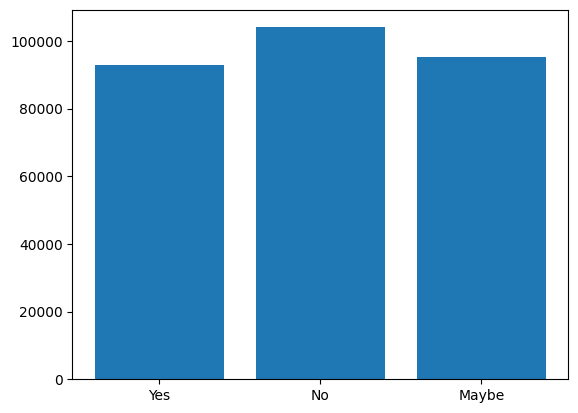

In [339]:
col = data.Mental_Health_History
y = col.groupby(col).count()
y = y.reindex(['Yes', 'No', 'Maybe'])
x = y.index
print(f'Missing values in Mental_Health_History: {sum(col.isnull())}')
fig = plt.bar(x, y)

Overall there is an even spread of values across yes, no and maybe, which bodes well for prediction. One consideration to take into account here, however, is that people may be uncomfortable or unwilling to disclose their truthful mental health history in a survey, resulting in a higher proportion of "No's" and "Maybe's" in the dataset than what may be truthful. The kaggle site did not mention whether this was a survey done in person or online, which depending on the specific mode of survey taking may make this factor more or less impactful in revealing the true situation.

In [340]:
# Transforming mental health history variable into three categories, -1 for No, 0 for Maybe, 1 for Yes
data.Mental_Health_History = data.Mental_Health_History.apply(lambda x: -1 if x == 'No' else 0 if x == 'Maybe' else 1)

##### Timestamp

Number of null values:  0


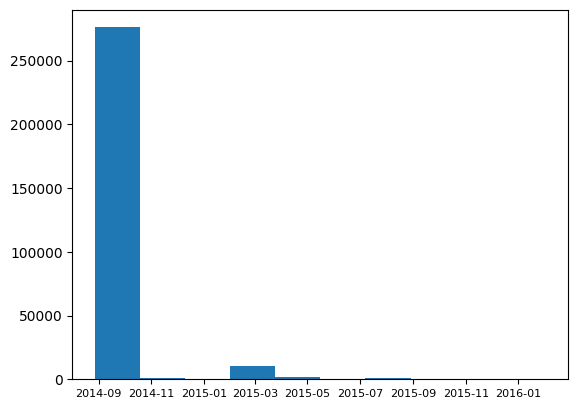

In [341]:
# Timestamp data is unable to really be categorized, need to change the datatype
data.Timestamp = pd.to_datetime(data.Timestamp)
x = data.Timestamp
print('Number of null values: ', sum(x.isnull()))
fig = plt.hist(x)
fig = plt.xticks(fontsize = 8)

Looks like most of the surveys were submitted exactly when the survey was put out. Overall I don't think this column will have much of an effect on prediction, given that the date someone completes a survey isn't likely at all to have any correlation to mental illness, etc.

##### Gender

<BarContainer object of 2 artists>

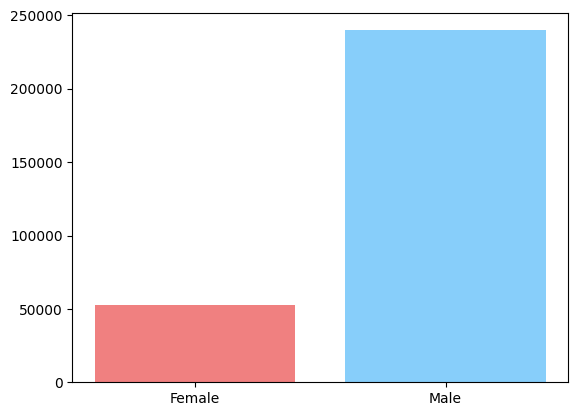

In [342]:
# Looking at gender types
col = data.Gender
y = col.groupby(col).count()
x = y.index
plt.bar(x, y, color = ['lightcoral', 'lightskyblue'])

The smaller population of women compared to men will likely result in a reduction in accuracy for women, as well as potentially leading to biased results for either men or women in the eventual model.

In [426]:
# Transforming the gender into model usable variable
# I want to do this one by one to make it so that the column names will be more readable, etc.
data[['Female', 'Male']] = pd.get_dummies(data.Gender)
data = data.drop('Gender', axis = 1)

AttributeError: 'DataFrame' object has no attribute 'Gender'

##### Country

In [478]:
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

world = gpd.read_file('data/ne_110m_admin_0_countries.shp')
col = data.Country
y = col.groupby(col).count()
x = y.index
countries = pd.DataFrame(np.array([x, y]).T)
countries = countries.rename({0: 'country', 1: 'count'}, axis = 1)
world = world.rename(columns={"NAME": "country"})
merged = pd.merge(world, countries, left_on = 'NAME_EN', right_on = 'country', how = 'left')

In [479]:
x, y = countries.country.count(), sum(merged['count'].notnull())
print(f'Before imputing.\nTotal countries with counts: {x}\nTotal countries in merged dataset with counts: {y}')
# Individually adding in count for countries that do not have the proper matching name
merged.loc[merged[(merged.NAME_EN == 'United States of America') == True].index, 'count'] = 171308
# There is no singapore, so we will put it as part of malaysia, this is due to the fault of the specific dataset not containing mapping data for singapore
merged.loc[merged[(merged.NAME_EN == 'Malaysia') == True].index, 'count'] = 780
x, y = countries.country.count(), sum(merged['count'].notnull())
print(f'After imputing.\nTotal countries with counts: {x}\nTotal countries in merged dataset with counts: {y}')
# Making count numeric and filling in missing values with 0
merged['count'] = pd.to_numeric(merged['count'])
merged['count'] = merged['count'].fillna(np.float64(0))

Before imputing.
Total countries with counts: 35
Total countries in merged dataset with counts: 33
After imputing.
Total countries with counts: 35
Total countries in merged dataset with counts: 35


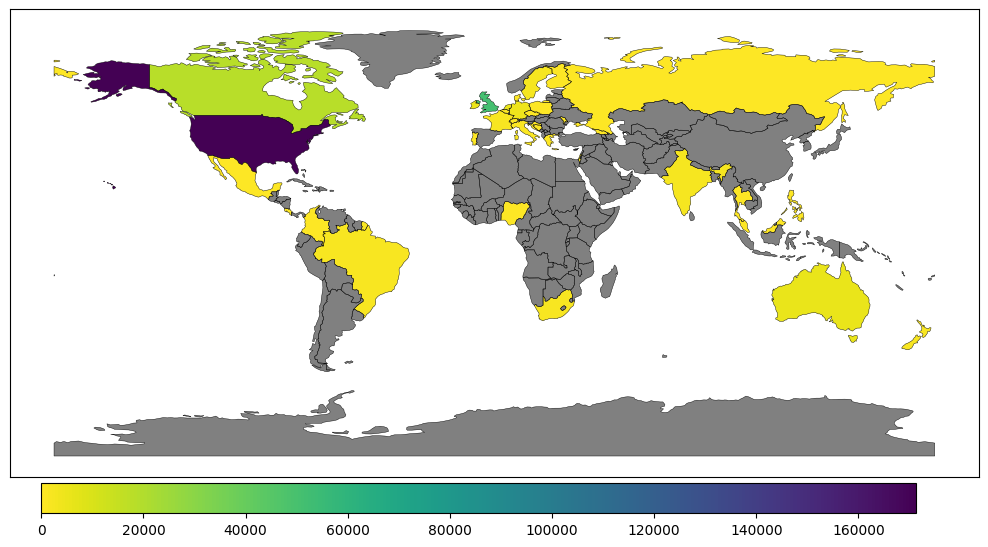

In [551]:
fig, ax = plt.subplots(1, 1, figsize = [12.5, 10])
norm = mcolors.Normalize(vmin = merged['count'].min(), vmax = merged['count'].max())
cmap = plt.get_cmap('viridis_r')
patches = []

ax.set_yticks([])
ax.set_xticks([])
merged.boundary.plot(ax = ax, linewidth = 0.3, color = 'black')
merged[merged['count'] != 0].plot(label = 'count', column = 'count', ax = ax,cmap = cmap)
merged[merged['count'] == 0].plot(ax=ax, color='gray')
# Creating legend
from matplotlib.colorbar import ColorbarBase
cbar_ax = fig.add_axes([0.15, 0.225, 0.7, 0.03])
cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')

From the plot above, we can see that most of the survey responses come from typically labelled "Western" countries, with Eastern country responses being more rare. This means that the results cannot be generalized for the entire populace, but only really for the countries that make up a large proportion of the survey responses. This also means that the mental health results also will not encompass countries such as China or South Korea, countries regularly shown in the news for mental health issues and problems, which may have been interesting to see. Overall it doesn't seem as if country will be a valuable predictor, considering that most of the responses come from only a few countries.